It is a sample notebook for illustration purposes only. We recommend including the below cell with important candidate instructions.
You may need to update the OS and package versions based on the current environment.

### Environment
Ubuntu 22.04 LTS which includes **Python 3.9.12** and utilities *curl*, *git*, *vim*, *unzip*, *wget*, and *zip*. There is no *GPU* support.

The IPython Kernel allows you to execute Python code in the Notebook cell and Python console.

### Installing packages
- Run `!mamba list "package_name"` command to check the package installation status. For example,

```python
!mamba list numpy
"""
# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
numpy                     1.21.6           py39h18676bf_0    conda-forge
"""
```

    You can also try importing the package.

- Run the `!mamba install "package_name"` to install a package

### Excluding large files
HackerRank rejects any submission larger than **20MB**. Therefore, you must exclude any large files by adding these to the *.gitignore* file.
You can **Submit** code to validate the status of your submission.

## Introduction

The Occupational Employment and Wage Statistics (OEWS) program produces employment and wage estimates annually for nearly 800 occupations. These estimates are available for the nation as a whole, for individual states, and for metropolitan and nonmetropolitan areas; national occupational estimates for specific industries are also available.

## Problem

The data used in this problem is a subset of the OEWS data, which include the 10-th percentile, 25-th percentile, 50-th percentile (a.k.a median), 75-th percentile, and 90-th percentile of the annual salary of a given combination of states, industries, and occupations.

One needs to use the data in _train.csv_ to train a machine learning model to predict the 10-th, 25-th, 50-th, 75-th and 90-th percentiles of the given combinations in _submission.csv_.

## Data

### Independent Variables

There are three independent variable columns:
- PRIM_STATE
- NAICS_TITLE
- OCC_TITLE

indicating the state, industry, and occupation.

NOTE:
- In the _PRIM_STATE_ variable, each category indicates a state postal abbreviation (like "_CA_", "_TX_", etc.) or "_U.S_" as the whole United States. When _PRIM_STATE_ is "_U.S_", it means the percentiles are aggregated across all the states.
- In thes _NAICS_TITLE_, each category indicates an industry sector name (like "_Retail Trade_", "_Manufacturing_") or "_Cross-industry_". When _NAICS_TITLE_ is "_Cross-industry_", it means the percentiles are aggregated across all the industries.

### Target Variables

There are 5 dependent (target) variable columns:
- A_PCT10
- A_PCT25
- A_MEDIAN
- A_PCT75
- A_PCT90

indicating the 10-th percentile, 25-th percentile, median, 75-th percentile, 90-th percentile of the annual base salary given the state, industry, and occupation information.

**IMPORTANT**: the percentiles should follow an increasing order. Namely, the 10-th percentile is less than (<) the 25-th percentile, the 25-th percentile is less than (<) the 50-th percentile, etc.

## Deliverables

### Submit a Well commented Jupyter Notebook

Explore the data, make visualizations, and generate new features if required. Make appropriate plots, annotate the notebook with markdowns and explain necessary inferences. A person should be able to read the notebook and understand the steps taken as well as the reasoning behind them. The solution will be graded on the basis of the usage of effective visualizations to convey the analysis and the modeling process.


### Submit _submission.csv_

In the given _submission.csv_, values in the "A_PCT10", "A_PCT25", "A_MEDIAN", "A_PCT75", and "A_PCT90" columns are constants, and you need to replace them with your model predictions.

**IMPORTANT**:
- please do not change the header given in _submission.csv_, or your predictions may not be evaluated correctly.
- Your Jupyter Notebook should be able to generate your submitted predictions.



## Evaluation Metric

The model performance is evaluated by the mean normalized weighted absolute error (MNWAE) defined as the following:
$$ MNWAE = \frac{1}{n} \sum_{i=1}^{n} \sum_{j \in \{10, 25, 50, 75, 90\}} w_j \times \frac{|y_{i,j}-z_{i,j}|}{z_{i,j}}$$
where $y_{i,j}$ and $z_{i,j}$ are the model estimation and the ground truth of the $i$-th row and $j$-th percentile, and
$$ w_{10} = w_{90} = 0.1, $$
$$ w_{25} = w_{75} = 0.2, $$
$$ w_{50} = 0.4 $$

For example, if

actual percentiles = [10000, 30000, 60000, 80000, 100000],

predicted percentiles = [11000, 33000, 54000, 88000, 120000],

normalized weighted absolute error = 0.1*|11000-10000|/10000+0.2*|33000-30000|/30000+0.4*|54000-60000|/60000+0.2*|88000-80000|/80000+0.1*|120000-100000|/100000 = 0.11

**IMPORTANT**: if the predicted percentiles in any row do not follow an increasing order, all the predictions will be considered as invalid.

## Solution ..

In [ ]:
# Import the `pandas` library to load the dataset
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
import numpy as np
from category_encoders import TargetEncoder
import category_encoders as ce

In [ ]:
df_train = pd.read_csv('train.csv')

In [ ]:
df_train.head()

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,"Arts, Entertainment, and Recreation",Supervisors of Transportation and Material Mov...,"32,350.000","40,200.000","50,790.000","62,560.000","78,520.000"
1,US,"Mining, Quarrying, and Oil and Gas Extraction","Sales Representatives, Wholesale and Manufactu...","47,860.000","61,600.000","87,810.000","107,460.000","153,600.000"
2,US,Finance and Insurance,Physical Scientists,"59,240.000","63,050.000","89,740.000","126,320.000","149,070.000"
3,US,Administrative and Support and Waste Managemen...,"Architects, Surveyors, and Cartographers","37,320.000","47,630.000","60,550.000","77,450.000","98,990.000"
4,US,Manufacturing,Supervisors of Protective Service Workers,"50,130.000","63,840.000","81,770.000","104,530.000","133,180.000"


### Checking for Nan or Null Values in Dataset

In [ ]:
df_train.isnull().sum()

PRIM_STATE       0
NAICS_TITLE      0
OCC_TITLE        0
A_PCT10          0
A_PCT25          0
A_MEDIAN         0
A_PCT75         30
A_PCT90        139
dtype: int64

Since, A_PCT75 and A_PCT90 contains nulls Value, we need to replace it with some numerial values in order to train a model

### Performing Imputation

Imputation is used to replace all the null or NaN values with numerical data which is mostly a median or mean

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(df_train[["A_PCT75", "A_PCT90"]]) 
df_train[["A_PCT75", "A_PCT90"]] = imputer.transform(df_train[["A_PCT75", "A_PCT90"]])

In [ ]:
i = 1
for col in df_train.columns:
    if i <= 3:
        print(col, ' : ', len(df_train[col].unique()), ' Labels')
        i += 1
    else:
        break

PRIM_STATE  :  52  Labels
NAICS_TITLE  :  21  Labels
OCC_TITLE  :  116  Labels


There are multiple categorial values which are needed to be transform into numerical value. For this mainly One Hot Encoding is used widely. However, using One Hot Encoding, the dimenisionality of the dataset would increased drastically which would effect model performance. Further, Frequency, Count or Label Encoding are also not the best choose as it would create unwanted realtionship between data attributes. So, for this dataset, Leave One Out Encoder which is one form of Target Encoding would be the best choice.


### Encoding Categorial Independents Attributes using Leave One Out Encoder
- The dataset consist of three Nominal Categorial Attributes which requires to be transform into numerial before passing to the model for training.
- Here, Leave One Out Encoder is used to encode a categorial data by performing target encoding by leaving out the current row while assigning values to each label.
- For Target, A_Median is taken which consist of median value amongs all 5 Target Variables. We could also create new feature Target Mean which is the mean of all 5 Target Variable by using 
  
  `a_mean = df_train.iloc[:, 3:8].values.mean(axis=1)`. However, the mean is vunerable to outliers and hence, the performance of the model would decrease if mean is used rather than median 

In [ ]:
class EncodeCatData:
    def __init__(self, prim_state, naics_title, occ_title, a_median):
        self.encoderp = ce.LeaveOneOutEncoder()
        self.encodern = ce.LeaveOneOutEncoder()
        self.encodert = ce.LeaveOneOutEncoder()
        self.prim_state_encode = self.encoderp.fit_transform(prim_state, a_median)
        self.naics_title_encode = self.encodern.fit_transform(naics_title, a_median)
        self.occ_title_encode = self.encodert.fit_transform(occ_title, a_median)
    
    def ReturnFitTransformData(self):
        return pd.concat([self.prim_state_encode, self.naics_title_encode, self.occ_title_encode], axis=1)
    
    def ReturnTransformData(self, prim_state, naics_title, occ_title):
        df_sub_PS = self.encoderp.transform(prim_state)
        df_sub_NT = self.encodern.transform(naics_title)
        df_sub_OT = self.encodert.transform(occ_title)
        return pd.concat([df_sub_PS, df_sub_NT, df_sub_OT], axis=1)

encoder = EncodeCatData(df_train['PRIM_STATE'], df_train['NAICS_TITLE'], df_train['OCC_TITLE'], df_train['A_MEDIAN'])
df_train_X = encoder.ReturnFitTransformData()
print('Shape => Rows:', df_train_X.shape[0], 'and Columns:', df_train_X.shape[1])
df_train_X.head(5)


Shape => Rows: 2297 and Columns: 3


,PRIM_STATE,NAICS_TITLE,OCC_TITLE
0,"57,977.842","46,798.667","57,797.000"
1,"57,953.113","74,426.667","65,985.000"
2,"57,951.824","72,464.857","90,086.364"
3,"57,971.323","51,524.487","79,007.692"
4,"57,957.148","63,210.000","66,091.538"


Now, Assigning the Independent Attributes to Variable 'X' and Dependent (Target) Attributes to Varibale 'y'

In [ ]:
X = df_train_X.values
y = df_train.iloc[:, 3:8].values

Splitting the dataset for training and testing the model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 32)

The correlation between different indepedent attributes could be seen below. The high value show higher correlation between attributes

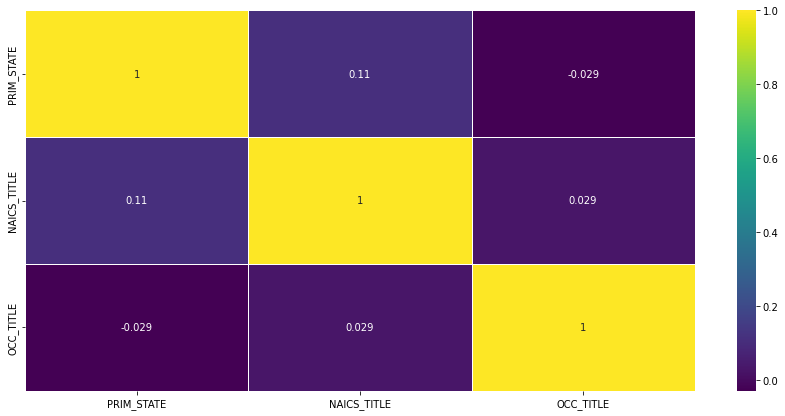

In [ ]:
import seaborn as sns
import mglearn
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 7))
sns.heatmap(df_train_X[["PRIM_STATE", "NAICS_TITLE", "OCC_TITLE"]].corr(), annot=True, cmap='viridis', linewidths=.5)
plt.show()

Since, the values of correlation are small, no need to reduce the dimensions using reduction techniques such as PCA, LDA, AutoEncoders, etc...

### Training the Random Forest Regressor Model

For Training, Random Forest Regressor is used to determine five target varibles using 3 categorical independent attributes.

Random Forest Regressor consist of multiple decision trees combined together to determine the final outcome by aggregating different decision trees. 

For this dataset, Random Forest Regressor is chosen as it lower the resultant high variance of decision tree which is a problem with individual Decision tree. 

Here, the process named Bagging take place where, the input is boostrap to individual decision trees and then the outcome of individual decision tree is aggregated to the targeted outcome.

The diagram of Random Forest Model is shown below:

![image](img/RandomForestRegressor.png)

(Image Source: https://www.geeksforgeeks.org/random-forest-regression-in-python/)

For Hyperparameter tuning, GridSearchCV is used that tries out different specifed combinations to return the best estimator for training the model.

```python
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50],
    'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [3, 4, 5, 6, 7],
    'min_samples_split': [3, 4, 5, 6, 7, 8, 10, 12, 14, 16],
    'n_estimators': [50, 75, 100, 110, 125, 150, 160, 175, 200, 500, 750, 1000]
}

rf = RandomForestRegressor(random_state=12)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0)
grid_search.fit(X_train, y_train)

```
For determining the best estimator
```python
best_grid = grid_search.best_estimator_
best_grid
```
Output:
> RandomForestRegressor(max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=3, n_estimators=150, random_state=12)

Another possible Hyperparameter that would provide better result are

```python
model = RandomForestRegressor(n_estimators=1000, random_state=12)
model.fit(X_train, y_train)
```
which gives mean evalution score of 0.5436, however, it takes much longer (3.7sec on local device) to train and predict the result.

and 

```python
model = RandomForestRegressor(max_depth=20, max_features=2, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=150, random_state=12)
```
which is another alternative hyperparameter.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=20, max_features=2, min_samples_leaf=3,
                      min_samples_split=3, n_estimators=150, random_state=12)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features=2, min_samples_leaf=3,
                      min_samples_split=3, n_estimators=150, random_state=12)

### Evaluating the Model using Mean Normalized Weighted Absolute Error (MNWAE)

In [ ]:
def EvalutionScore(y_pred, y_true):
    eval = []
    coeff = (0.1, 0.2, 0.4, 0.2, 0.1)
    for i in range(y_pred.shape[0]):
        score = 0
        for j in range(5):
            score += (coeff[j]*abs(y_pred[i][j] - y_true[i][j])/y_true[i][j])
        eval.append(score)
    return eval, max(eval), min(eval), np.average(eval), np.median(eval), 

y_pred = model.predict(X_test)
print('Max Evaluation Score: ', EvalutionScore(y_pred, y_test)[1])    
print('Min Evaluation Score: ', EvalutionScore(y_pred, y_test)[2])    
print('Avg Evaluation Score: ', EvalutionScore(y_pred, y_test)[3])    
print('Median Evaluation Score: ', EvalutionScore(y_pred, y_test)[4])    

Max Evaluation Score:  0.4118979242168036
Min Evaluation Score:  0.0035646601301991274
Avg Evaluation Score:  0.0558426822231227
Median Evaluation Score:  0.040783613423958864


### Visualizing the Target Variable (Salaries) Based on Predicted and True Values
The below given Graph shows the differences between the real (True) values and the predicted values in salaries.
Since, we train model on A_Median Attribute, we are avoiding the outliers which could be seen if the average of target attributes is used rather than Median Values.

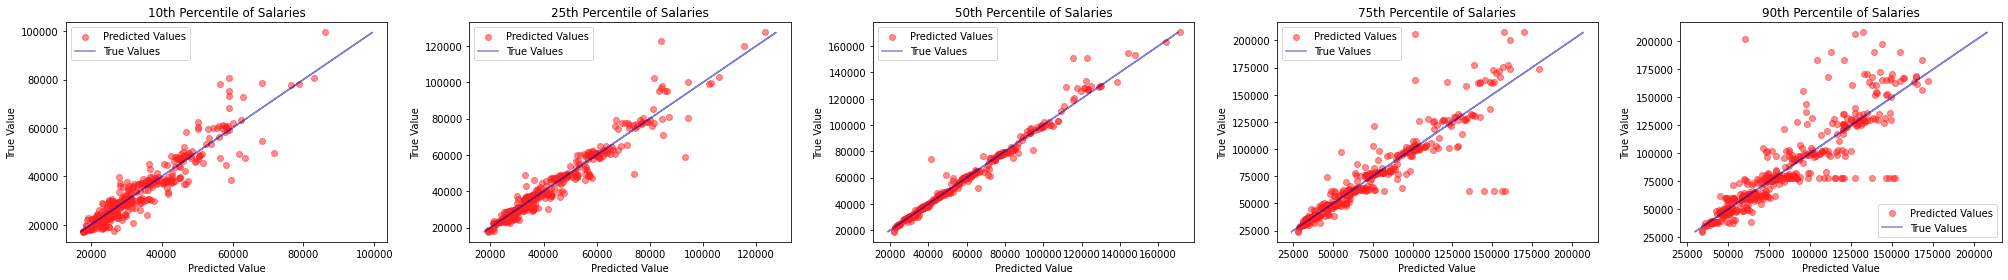

In [ ]:
lb = (10, 25, 50, 75, 90)
fig, ax = plt.subplots(1,5, figsize=(28, 4))

for i in range(5):
    ax[i].scatter(y_pred[:, i], y_test[:, i], color=mglearn.cm3(1), alpha=.5, label="Predicted Values")
    ax[i].plot(y_test[:, i], y_test[:, i], color=mglearn.cm3(0), alpha=.5, label="True Values")
    # print(lb[i])
    ax[i].set_title('{x}th Percentile of Salaries'.format(x = lb[i]))
    ax[i].set_xlabel('Predicted Value')
    ax[i].set_ylabel('True Value')
    ax[i].legend(loc="best")
    # plt.figure(figsize = (10, 10))
    # plt.subplot(2, 3, i+1)
fig.tight_layout()

### Predicting the Submission Data

In [ ]:
df_sub = pd.read_csv('submission1.csv')
df_sub.head(5)

,Unnamed: 0,Unnamed: 0.1,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,0,0,US,Accommodation and Food Services,Other Production Occupations,"32,243.239","40,746.801","55,730.007","71,501.710","92,225.616"
1,1,1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...","28,177.123","34,220.980","45,491.970","62,500.150","80,586.798"
2,2,2,US,Manufacturing,Construction and Extraction Occupations,"33,951.418","42,953.995","58,035.727","73,297.065","88,839.766"
3,3,3,US,Wholesale Trade,Material Moving Workers,"29,869.345","36,784.337","51,971.205","68,492.690","85,481.394"
4,4,4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,"32,689.205","42,292.992","57,668.323","73,933.582","91,416.546"


Selecting the Independent Attributes and assigning it to X_sub

In [ ]:
X_sub = df_sub[["PRIM_STATE", "NAICS_TITLE", "OCC_TITLE"]]
X_sub.head(5)

,PRIM_STATE,NAICS_TITLE,OCC_TITLE
0,US,Accommodation and Food Services,Other Production Occupations
1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media..."
2,US,Manufacturing,Construction and Extraction Occupations
3,US,Wholesale Trade,Material Moving Workers
4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...


### Transforming the Independent Attributes with the same Encoder which is used while training the Model
The Model is already train using the encoded Attributes and the same encoding of attributes is required for making prediction.

In [ ]:
# Transform the categorical attributes given in submission file
df_sub_X = encoder.ReturnTransformData(df_sub['PRIM_STATE'], df_sub['NAICS_TITLE'], df_sub['OCC_TITLE'])
print('Shape => Rows:', df_sub_X.shape[0], 'and Columns:', df_sub_X.shape[1])
df_sub_X.head(5)

Shape => Rows: 926 and Columns: 3


,PRIM_STATE,NAICS_TITLE,OCC_TITLE
0,"57,973.044","43,869.420","42,731.667"
1,"58,884.167","53,241.469","51,948.958"
2,"57,973.044","63,444.937","50,937.600"
3,"57,973.044","60,310.000","34,665.000"
4,"57,973.044","50,927.765","50,312.727"


### Making Predictions

In [ ]:
subrY = model.predict(df_sub_X.values)

# Display first 5 predicted value
subrY[:5,:]

array([[32243.23860991, 40746.80145743, 55730.0074026 , 71501.70962482,
        92225.61564214],
       [28177.12280423, 34220.97960317, 45491.96960317, 62500.14968254,
        80586.79756614],
       [33951.41831835, 42953.99473175, 58035.7268291 , 73297.06535058,
        88839.76559922],
       [29869.34537074, 36784.33666833, 51971.20488437, 68492.68984293,
        85481.39418396],
       [32689.20534447, 42292.99190865, 57668.32281644, 73933.58174418,
        91416.54584157]])

### Replace the dependent Attributes Values in Submission File

In [ ]:
# Default Values gievn in the dataset
df_sub[["A_PCT10", "A_PCT25", "A_MEDIAN", "A_PCT75", "A_PCT90"]].head()

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,"32,243.239","40,746.801","55,730.007","71,501.710","92,225.616"
1,"28,177.123","34,220.980","45,491.970","62,500.150","80,586.798"
2,"33,951.418","42,953.995","58,035.727","73,297.065","88,839.766"
3,"29,869.345","36,784.337","51,971.205","68,492.690","85,481.394"
4,"32,689.205","42,292.992","57,668.323","73,933.582","91,416.546"


In [ ]:
# Replacing the given values with the predicted value 
df_sub[["A_PCT10", "A_PCT25", "A_MEDIAN", "A_PCT75", "A_PCT90"]] = subrY
df_sub[["A_PCT10", "A_PCT25", "A_MEDIAN", "A_PCT75", "A_PCT90"]].head()

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,"32,243.239","40,746.801","55,730.007","71,501.710","92,225.616"
1,"28,177.123","34,220.980","45,491.970","62,500.150","80,586.798"
2,"33,951.418","42,953.995","58,035.727","73,297.065","88,839.766"
3,"29,869.345","36,784.337","51,971.205","68,492.690","85,481.394"
4,"32,689.205","42,292.992","57,668.323","73,933.582","91,416.546"


### Saving the Predicted Outcome

In [ ]:
# df_sub.to_csv()
df_sub.to_csv('submission1.csv')